# PDF Data Extraction Notebook -- Cell Based

#### This notebook demonstrates how to extract text from a PDF when the PDF is a highly structured document.
Many types of government forms (e.g. IRS' 1040) have been designed to guide the human eye when filling out the form. The page is highly structured, with tables, boxes, dividing lines, white space, etc. Such forms can confuse OCR processes. Vertical lines can be read as '1' or 'l', horizontal lines can make '.' and ',' invisible, and all the white space can confuse the system on when to insert line breaks.

To overcome this issue, I've found it works well to take that complex initial document and split it into many simplier image. I do this by identifying long, straight lines on the page, and subdividing the image of the page into chunks based on those lines. The example in this notebook only looks for the longest lines in the form, but a full application would be an iterative process. Looking for long lines in each new subimage, which would in turn keep breaking the subimages into smaller and simplier pieces.

### Pipeline:
1. Given pdf, convert into images with ghostscript
2. Given an image, identify long horizontal and vertical lines.
3. Split image into many subimages (cells) based on the found horizontal and vertical lines.
4. OCR each cell.
5. Combine results in csv.

### Tools:
* ghostscript -- to convert pdfs to images so that they can be OCR'd.
* tesseract -- to extract text from images
* python -- glue to run ghostscript, tesseract, perform image manipulations, and compile results

#### The main features of this notebook (converting PDFs to PNGs and OCRing PNGs to extract text) are not done by Python. They are being done by command line tools GhostScript and Tesseract. Those need to be installed before this notebook will do anything.

Starter places for easy installs of those tools:
1. Tesseract: https://github.com/UB-Mannheim/tesseract/wiki -- A full installer for Windows. But hosted outside the US. Domestic installers for older versions of Tesseract may be found here: https://github.com/tesseract-ocr/tesseract/wiki/4.0-with-LSTM#400-alpha-for-windows

2. Ghostscript: https://www.ghostscript.com/download/gsdnld.html

#### Ghostscript and Tesseract where both installed on a Windows 10 laptop when creating this demo. The tools were installed in subfolders of this projects folder. When being called by the Python OS package in the code below, the relative filepath is being given to the executable application files. 

## 0. Importing required Python packages.

In [1]:
import os #for navigating folder structures and running command line tools ghostscript and tesseract
import matplotlib.pyplot as plt #for visualizing steps in this notebook
from PIL import Image #for visualizing results and manipulating images
from matplotlib.patches import Rectangle #for visualizing image manipulation
import numpy as np #for maths and manipulating images
import pandas as pd#for storing results at end of pipeline
import tempfile #for creating temp folder to store images and text files

In [2]:
tempDir=tempfile.mkdtemp(dir=os.getcwd())

## 1. Convert a PDF into image(s)

Tesseract works on images, so the first step needs to be converting the PDFs into images. If the PDF is multipage, we want to have access to each of those pages, so we'll save each page as its own file. When working with a collection of, say, 100+ page PDFs, this can quickly generate a huge amount of image data. For those production level processes, the images should be deleted after OCRing to reduce storage issues.

GhostScript is the command line tool I will use to convert the PDF into PNGs. Ghostscript has additional options than those shown here (see https://www.ghostscript.com/doc/current/Use.htm ). The ones used here:

* -sDEVICE -- Tell ghostscript what to convert the PDF into. In this case, PNGs.
* -sOutputFile -- The filepath and name of image to save.
* -dBATCH -- Quit ghostscript after completing the batch of 1+ PDF to PNG conversions.
* -dNOPAUSE -- Skip any user prompts that Ghostscript would normally ask for when running as command line tool.
* -rnumber -- Hor. and ver. resolution in pixels per inch. Higher number--> more detail and often better OCR, but Ghostscript takes longer.
* The final option is the input PDF file to convert.

Below, making use the of %s string variable to insert the filepaths for the location to save the image(s) and the location of the original PDF.


In [3]:
os.listdir('examplePDFs')

['claim-form-cms-1500-filled.pdf',
 'claim-form-cms-1500.pdf',
 'f1040.pdf',
 'form-or-stt-1_206-003_2018.pdf',
 'OTC-Payment-Voucher.pdf']

In [4]:
#target pdf. Currently being pulled from the examples included in the GitHub project.
targetPDF=os.path.join('examplePDFs','f1040.pdf')

In [5]:
#save location:
PDFImages=os.path.join(tempDir, 'PDFImages')
try:
    os.mkdir(PDFImages)
except:
    print('directory already exists. Cleaning out for next data run')
    for file in os.listdir(PDFImages):
        os.remove(os.path.join(PDFImages, file))
imageSave=os.path.join(PDFImages,
                       '.'.join(os.path.basename(targetPDF).split('.')[:-1])+'-%03d.png') #add page number for multipage PDFs when creating images.

In [6]:
p = os.popen("GhostScript\\gs9.27\\bin\\gswin64c.exe -sDEVICE=pngalpha -sOutputFile=%s -dBATCH -dNOPAUSE -r288 %s"%(imageSave, targetPDF))
print(p.read())

GPL Ghostscript 9.27 (2019-04-04)
Copyright (C) 2018 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 2.
Page 1
Page 2



## 1.5 Visualize the converted image:

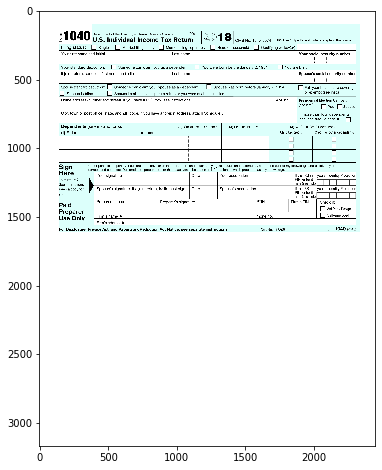

In [7]:
targetImage='f1040-001.png'
targetImage=os.path.join(PDFImages, targetImage)
im = Image.open(targetImage)
plt.figure(figsize=(12,8))
plt.imshow(np.array(im))

## 3. Image manipulation

#### Finding long horizontal and vertical lines in the form and using those to create many simplier subimages for OCRing.
Because this can generate a large number of extra images and eventually text files, creating folder to save them in.

In [8]:
subimagepath=os.path.join(tempDir, 'subimages')
try:
    os.mkdir(subimagepath)
except:
    print('subimage folder already exists. Cleaning out for next run...')
    for file in os.listdir(subimagepath):
        os.remove(os.path.join(subimagepath, file))

In [9]:
im2=np.array(im)[:,:,1] #easier to work with 2D array, but am losing some info about the other color channels.
#Collapsing pixels down along vertical axis. This will cause long horizontal lines to show up as deep drops in the total:
dim=1 #setting to look at horizontal lines first:
pixelSum=im2.sum(axis=dim)
threshold=pixelSum.mean()*.35 #If value is lesss than this, consider it a long ddark line for splitting the image.
#option to plot:
# plt.plot(pixelSum)
# plt.axhline(y=threshold)
# plt.show()
#collecting locations of all horizontal lines 
cuts0=[i for i, x in enumerate(pixelSum) if x<=threshold]
cuts0=[0]+cuts0+[len(im2)]

#Now looking at vertical lines in each of the strips found above:
for x in range(0,len(cuts0)-1):
    a0=x#topcut
    b0=x+1#bottomcut
    imSub=im2[cuts0[a0]:cuts0[b0]]
    if len(imSub)>5: #ignore close horizontal lines (prob. same multipixel think line)
        #split along vertical lines:
        dim=0
        pixelSum2=imSub.sum(axis=dim)
        threshold2=pixelSum2.mean()*.25
        cuts1=[i for i, x in enumerate(pixelSum2) if x<=threshold2]
        cuts1=[0]+cuts1+[len(imSub[0])]
        for y in range(0, len(cuts1)-1):
            a1=y
            b1=y+1
            imSub1=imSub[:,cuts1[a1]:cuts1[b1]] #found subbox.
            if len(imSub1[0]>5):#ignore close vertical lines (prob. same multipixel think line)
                name='.'.join(os.path.basename(targetImage).split('.')[:-1])\
                     +'_'+'_'.join([str(elm) for elm in [cuts0[a0],cuts0[b0],cuts1[a1],cuts1[b1]]])+'.png'
                #plt.figure(figsize=(8, 24))
                #plt.imshow(imSub1, cmap='gray')
                #plt.show()

                #below: dropping a few pixel rows at top and bottom to remove horizontal lines.\
                #       adding white space padding on top and bottom to improve OCRing
                imSub1pad=np.concatenate([np.ones((50,len(imSub1[0])))*255,imSub1[4:-4],np.ones((50,len(imSub1[0])))*255])
                imSub1pad=imSub1pad.astype('uint8')
                subImage=Image.fromarray(imSub1pad)
                subImage.save(os.path.join(subimagepath, name)) #saving all the subimages in the same location
                #print(name)
#plt.imshow(imSub[:,cuts1[a1]:cuts1[b1]])

# Tesseract to extract text

Again, because there could be so many files, I'm creating a subfolder to stash everything.

In [10]:
subimageTextPath=os.path.join(tempDir, 'subimageText')
try:
    os.mkdir(subimageTextPath)
except:
    print('subimage folder already exists. Cleaning out for next run...')
    for file in os.listdir(subimageTextPath):
        os.remove(os.path.join(subimageTextPath, file))

In [11]:
for subimage in os.listdir(subimagepath):
    targetPath=os.path.join(subimagepath,subimage)
    savePath=os.path.join(subimageTextPath,'.'.join(subimage.split('.')[:-1]))
    p = os.popen('Tesseract\\tesseract.exe %s %s'%(targetPath, savePath))

Note: The notebook cell above could show as fully run, but tesseract could still be operating in the background. Give Tesseract a moment to finish up if no data is being seen in the extracted text folder.

## Compile data

In [12]:
df=pd.DataFrame(columns=['boxname','text'])

In [13]:
boxOCR=os.listdir(subimageTextPath)

In [14]:
for x in range (0, len(boxOCR)):
    try:
        df.loc[x,'boxname']=boxOCR[x]
        df.loc[x,'text']=open(os.path.join(subimageTextPath,boxOCR[x])).read()
    except:
        pass

In [15]:
df['HT']=-1
df['HB']=-1
df['VL']=-1
df['VR']=-1

In [16]:
for x in range(0, len(df)):
    df.loc[x, ['HT','HB','VL','VR']]=[int(elm.split('.')[0]) for elm in df.loc[x,'boxname'].split('_')[-4:]]

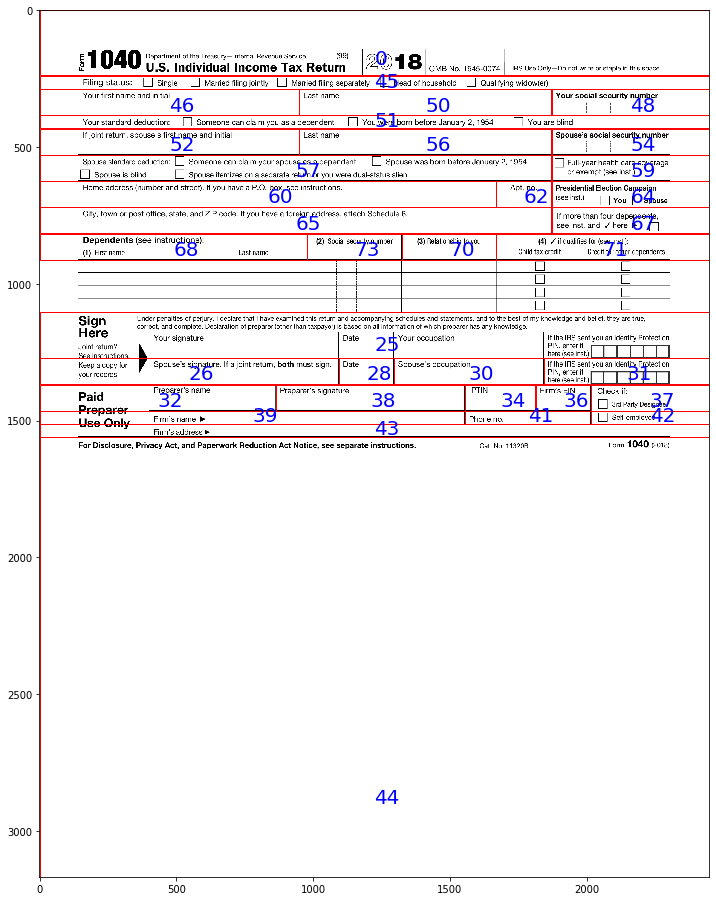

In [17]:
fig, ax = plt.subplots(1, figsize=(12,20))
ax.imshow(im2, cmap='gray')
for i in range(0, len(df)):
    #i=0
    xy=(df.loc[i,'VL'],df.loc[i,'HT']);
    width=df.loc[i,'VR']-df.loc[i,'VL'];
    height=df.loc[i,'HB']-df.loc[i,'HT'];
    if width > 20 and height >20 and len(str(df.loc[i,'text']).strip())>0:
        rect=Rectangle(xy, width, height,
                      edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.annotate(i, (int(xy[0]+width/2),int(xy[1]+height/1.2)), color='blue',fontsize=20)

E 1 040 Department of the Treasuryâ€”Internal Revenue Service 2 O 4 8
& U.S. Individual Income Tax Return OMB No. 1545-0074 | IRS Use Onlyâ€”Do not write or staple in this space.



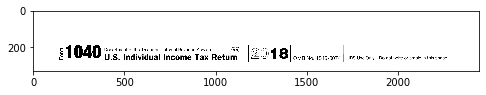

In [18]:
n=0
target='.'.join(df.loc[n,'boxname'].split('.')[:-1])+'.png'
plt.figure(figsize=[8, 12])
plt.imshow(np.array(Image.open(os.path.join(subimagepath,target))), cmap='gray');
print(df.loc[n,'text'])

Again, this example only looked for the longest horizontal and vertical lines to split the original image. So you may see some subimages above that could have been further split into smaller cells. To do that, change the code above to iterate over each subimage, performing the same test for lines to split the image on.

# 4. Clean up temp directory
Once everything has been completed, the temp files that were generated should be deleted.

In [19]:
for folder in ['PDFImages','subimages','subimageText']:
    try:
        for file in os.listdir(os.path.join(tempDir, folder)):
            os.remove(os.path.join(tempDir, folder,file))
        os.rmdir(os.path.join(tempDir, folder))
    except:
        pass
os.rmdir(tempDir)